In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import nibabel
import os
from pathlib import Path
import numpy as np
import pandas as pd

In [20]:
from mri import MRI

In [21]:
from bids_utils import BIDSDatabase
database = BIDSDatabase('bids/', 'results/')

In [22]:
res = database.get_all_func()

In [23]:
import pandas
import nilearn
from nilearn.image import index_img, concat_imgs

In [384]:
repetition_time = 2.39951

def get_svc_data(subjects, runs=range(0,4), mode='stim_vs_all'):

    global_data = {}
    
    for group, subject in enumerate(subjects):

        labels = pandas.read_csv(f'labels/labels_{subject}.csv')
        data = {}

        for run in runs:
            mask = labels['run'] == run + 1
            run_labels = labels[mask]

            times = np.around((run_labels['run time'].values)/ (1000*repetition_time)).astype(int)
            if mode == 'stim_vs_all':
                all_times = np.arange(res['%02d' %subject][run].shape[3])
                responses = np.in1d(all_times, times).astype(int)
            elif mode == 'human_responses':
                all_times = times
                responses = run_labels['response'].values

            data[run] = {'nii' : index_img(res['%02d' %subject][run].preprocessed, all_times), 
                         'labels' : responses,
                         'groups' : group * np.ones(len(responses))}
        
        run_volumes = concat_imgs([data[i]['nii'] for i in runs])
        run_labels = np.concatenate([data[i]['labels'] for i in runs])
        groups = np.concatenate([data[i]['groups'] for i in runs])
        mask = res['%02d' %subject][0].brain_mask
                    
        if not 'nii' in global_data:
            global_data = {'nii' : run_volumes, 
                           'labels' : run_labels, 
                           'groups' : groups, 
                           'mask' : mask}

        else:
            global_data['nii'] = concat_imgs([global_data['nii'], run_volumes])
            global_data['labels'] = np.concatenate([global_data['labels'], run_labels])
            global_data['groups'] = np.concatenate([global_data['groups'], groups])
            
    return global_data

In [387]:
global_data = get_svc_data(range(1,2), mode='stim_vs_all')

In [390]:
from sklearn.model_selection import LeaveOneGroupOut
#cv = LeaveOneGroupOut()

from nilearn.decoding import Decoder
from sklearn.svm import LinearSVC

decoder = Decoder(
    estimator='svc',
    mask=global_data['mask'],
    smoothing_fwhm=6,
    standardize=True,
    screening_percentile=5,
    scoring="roc_auc",
    #cv = cv,
    n_jobs=-1
)
    
#decoder.fit(global_data['nii'], global_data['labels'], groups=global_data['groups'])
decoder.fit(global_data['nii'], global_data['labels'])
print(decoder.cv_scores_[0])
print(decoder.cv_scores_[1])

/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear fail

[0.4864864864864865, 0.40180180180180186, 0.5633633633633633, 0.5021021021021022, 0.5633633633633633, 0.481280193236715, 0.4475308641975309, 0.4901234567901235, 0.5055555555555555, 0.5012345679012346]
[0.4864864864864865, 0.40180180180180186, 0.5633633633633633, 0.5021021021021022, 0.5633633633633633, 0.481280193236715, 0.4475308641975309, 0.4901234567901235, 0.5055555555555555, 0.5012345679012346]


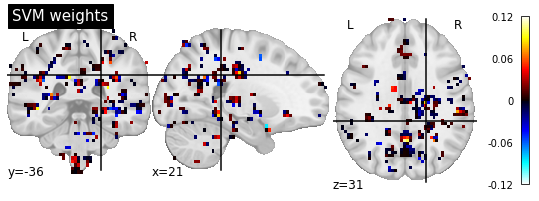

In [127]:
weight_img = decoder.coef_img_[0]
from nilearn.plotting import plot_stat_map, show

plot_stat_map(weight_img, title="SVM weights")

show()

In [24]:
morph_levels = np.load('morph_levels.npy')
morph_levels.shape

(25,)

In [ ]:
repetition_time = 2.39951
from pathlib import Path
import pylab as plt

global_data = {}
global_map = {}
reload_mode = True
make_plots = True

for subject in range(1, 25):
    
    print(f"Analyzing subject {subject}...")
    labels = pandas.read_csv(f'labels/labels_{subject}.csv')
    
    couples_to_exclude = np.loadtxt(f'labels/exclusion/couples_{subject}.csv')
    print(f"Couples {couples_to_exclude} should be ignored...")
    data = {}

    
    offset = 0
    runs = range(0, 4)
    
    morph_level = morph_levels[subject]
    
    if (morph_level < 20) or (morph_level > 80):
        print(f"Morph level is {morph_level} thus the subject {subject} is discarded...")
    else:
        print(f"Morph level is set to {morph_level} for subject {subject}...")
        for run in runs:
            mask = labels['run'] == run + 1
            run_labels = labels[mask]
            
            mask = ~np.in1d(run_labels['couple'], couples_to_exclude)
            run_labels = run_labels[mask]
            
            times = (run_labels['run time'].values)
            conditions = run_labels['morph level']
            idx_times = np.around((run_labels['run time'].values)/ (1000*repetition_time)).astype(int)

            try:
                nii_data = res['%02d' %subject][run].cleaned
            except Exception:
                print('Denoising not working!...')
                nii_data = res['%02d' %subject][run].preprocessed

            data[run] = {'nii' : index_img(nii_data, idx_times), 
                         'times' : times / 1000 + offset, 
                         'labels' : conditions}
            offset += repetition_time * nii_data.shape[3]

        run_volumes = concat_imgs([data[i]['nii'] for i in runs])
        run_times = np.concatenate([data[i]['times'] for i in runs])
        run_conditions = np.concatenate([data[i]['labels'] for i in runs])

        run_labels = np.concatenate([data[i]['labels'] for i in runs])
        mask = res['%02d' %subject][0].brain_mask

        events = pd.DataFrame(
            {'trial_type': [f'morph_{level}' for level in run_conditions], 
             'onset': run_times, 
             'duration': 0.5}
        )

        design_matrices = make_first_level_design_matrix(run_times, events,
                                      drift_model='polynomial', drift_order=3)

        from nilearn.glm.first_level import make_first_level_design_matrix
        if make_plots:
            from nilearn.plotting import plot_design_matrix
            plot_design_matrix(design_matrices)

            dir_path = Path(f'nilearn/{subject}')
            if not dir_path.exists():
                os.makedirs(dir_path)

            plt.savefig(dir_path / f'design_matrix.png')
            plt.close()

        from nilearn.glm.first_level import FirstLevelModel
        fmri_glm = FirstLevelModel(repetition_time, mask_img = mask, smoothing_fwhm=6)
        fmri_glm = fmri_glm.fit(run_volumes, design_matrices=design_matrices)

        contrast_matrix = np.eye(design_matrices.shape[1])
        contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrices.columns)
        }
        conditions = events.trial_type.unique()
        for condition in conditions:
            contrasts[condition] = np.sum(
                [
                    contrasts[name]
                    for name in design_matrices.columns
                    if name[: len(condition)] == condition
                ],
                0,
            )

        all_morphs = np.arange(5, 105, 10)

        contrasts["familiar"] = np.sum(
            [
                contrasts[f'morph_{level}']
                for level in all_morphs[all_morphs > morph_level]],
            0
        )
        contrasts["not familiar"] = np.sum(
            [
                contrasts[f'morph_{level}']
                for level in all_morphs[all_morphs < morph_level]],
            0
        )

        new_contrasts = {"familiar - not familiar" : contrasts["familiar"] - contrasts["not familiar"], 
                        "familiar" : contrasts["familiar"],
                        "not familiar" : contrasts["not familiar"]}
        #for morph_level in range(15, 105, 10):
        #    new_contrasts[f"{morph_level} - 5"] = \
        #    contrasts[f"morph_{morph_level}"] - contrasts[f"morph_5"]

        import matplotlib.pyplot as plt
        from nilearn.plotting import plot_stat_map

        #fig = plt.figure(figsize=(11, 3))
        for index, (contrast_id, contrast_val) in enumerate(new_contrasts.items()):
            
            z_map = fmri_glm.compute_contrast(
                contrast_val, output_type="z_score"
            )
            if make_plots:
                #ax = plt.subplots(1, 1, squeeze=False)
                plot_stat_map(
                    z_map,
                    display_mode="z",
                    threshold=1,
                    title=contrast_id,
                    #axes=ax,
                    cut_coords=1,

                )
                plt.savefig(dir_path / f'{contrast_id}.png')
                plt.close()
            if contrast_id not in global_map:
                global_map[contrast_id] = [z_map]
            else:
                global_map[contrast_id] += [z_map]
            nibabel.save(z_map, dir_path / f'{contrast_id}.nii')
            

Analyzing subject 1...
Couples [1. 3. 4. 6. 9.] should be ignored...
Morph level is set to 27.391383619530046 for subject 1...


In [55]:
global_z_maps = {}
for key, value in global_map.items():
    data = nilearn.image.concat_imgs(value)
    global_z_maps[key] = nilearn.image.mean_img(data)

In [56]:
global_z_maps.keys()

dict_keys(['familiar - not familiar', 'familiar', 'not familiar'])

In [57]:
for key, value in global_map.items():
    print(key)
    nilearn.plotting.plot_stat_map(global_z_maps[key], threshold=0.25, title=key, output_file=f'{key}.png')
    #plt.close()

familiar - not familiar
familiar
not familiar


In [62]:
global_map

{'familiar - not familiar': [<nibabel.nifti1.Nifti1Image at 0x7f31b6a2b250>,
 'familiar': [<nibabel.nifti1.Nifti1Image at 0x7f31b6b7fac0>,
 'not familiar': [<nibabel.nifti1.Nifti1Image at 0x7f31b6204b50>,
  <nibabel.nifti1.Nifti1Image at 0x7f31ab5a43a0>]}

In [103]:
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

decoder = Decoder(
    estimator="svc",
    mask = mask,
    standardize=False,
    screening_percentile=50,
    cv=LeaveOneGroupOut(),
    n_jobs=-1,
    #scoring="roc_auc",
)

svc_data = global_map['familiar'] + global_map['not familiar']
conditions = [0] * len(global_map['familiar']) + [1] * len(global_map['not familiar'])
session_label = np.tile(np.arange(23), 2)

decoder.fit(svc_data, conditions, groups=session_label)

# Return the corresponding mean prediction accuracy compared to chance

classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
chance_level = 1.0 / len(np.unique(conditions))
print(
    "Classification accuracy: {:.4f} / Chance level: {}".format(
        classification_accuracy, chance_level
    )
)

/home/cure/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   14    15    22   104   203   321   337   368   384   560   576   593
   646   804   845  1332  1354  1377  1401  1694  1842  2010  2034  2086
  2553  2600  2879  2908  3356  3391  3488  3668  3692  3846  4424  4779
  4805  4831  5005  5572  5596 11209 12393 13071 13990 14052 14405 14429
 15692 15749 16004 16056 16084 16105 16481 19121 19486 19504 19830 21203
 21221 22923 22940 24682 24855 25709 26424 26525 26557 26591 27419 28282
 28316 29878 29996 30030 31592 31707 31741 33282 33437 33471 33507 34399
 34794 35021 35047 35062 36755 36767 36795 36796 38503 38515 38524 38525
 38549 38565 39050 40263 40275 40284 40285 42030 42038 43748 43758 43932
 43968 44511 44548 45711 47395 47550 48523 49119 49158 49350 49387 50130
 50868 51108 51538 52032 52500 53512 54042 54914 54915 55875 56691 56717
 56743 57131 57214 57418 58264 58314 58476 60471 60727 60738 61774 618

Classification accuracy: 0.6522 / Chance level: 0.5
